# A Primer on Bayesian Methods for Multilevel Modeling

Hierarchical or multilevel modeling is a generalization of regression modeling. *Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**. Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another. Some multilevel structures are not hierarchical -- e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters. We will motivate this topic using an environmental epidemiology example.

## Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](https://www.cgenarchive.org/uploads/2/5/2/6/25269392/7758459_orig.jpg)

The EPA did a study of radon levels in 80,000 houses. There are two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county. 

## Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import warnings

print(f'Running on PyMC3 v{pm.__version__}')
warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8924
np.random.seed(286)

# Import radon data
srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN'].copy()

Running on PyMC3 v3.8


Next, obtain the county-level predictor, uranium, by combining two variables.

In [2]:
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

Use the `merge` method to combine home- and county-level information in a single DataFrame.

In [3]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [4]:
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We also need a lookup table (`dict`) for each unique county, for indexing.

In [5]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

Finally, create local copies of variables.

In [6]:
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

Distribution of radon levels in MN (log scale):

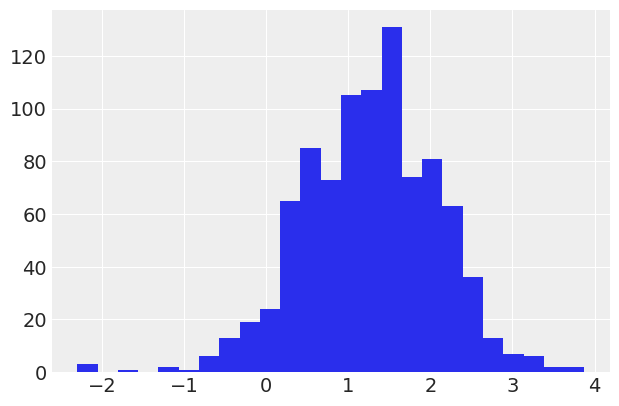

In [46]:
srrs_mn.log_radon.hist(bins=25);

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

We'll start by estimating the slope and intercept for the complete pooling model. You'll notice that we used an *index* variable instead of an *indicator* variable in the linear model below. There are two main reasons. One, this generalizes well to more-than-two-category cases. Two, this approach correctly considers that neither category has more prior uncertainty than the other. On the contrary, the indicator variable approach necessarily assumes that one of the categories has more uncertainty than the other: here, the cases when `floor=1` would take into account 2 priors ($\alpha + \beta$), whereas cases when `floor=0` would have only one prior ($\alpha$). But *a priori* we aren't more unsure about floor measurements than about basement measurements, so it makes sense to give them the same prior uncertainty.

Now for the model:

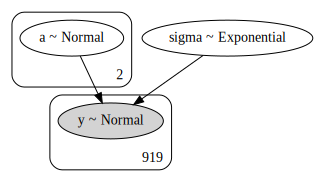

In [8]:
with pm.Model() as pooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=2)
    
    theta = a[floor]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
pm.model_to_graphviz(pooled_model)

Before running the model let's do some prior predictive checks. Indeed, having sensible priors is not only a way to incorporate scientific knowledge into the model, it can also help and make the MCMC machinery faster -- here we are dealing with a simple linear regression, so no link function comes and distorts the outcome space; but one day this will happen to you and you'll need to think hard about your priors to help your MCMC sampler. So, better to train ourselves when it's quite easy than having to learn when it's very hard...

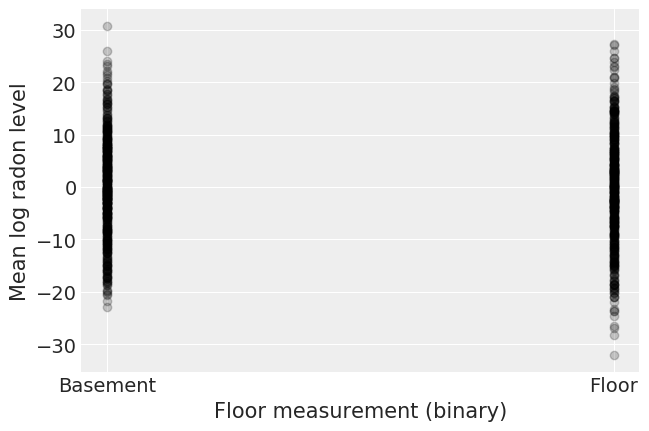

In [47]:
plt.plot(
    [0, 1], 
    [prior_checks["a"][:, 0], prior_checks["a"][:, 1]],
    "ok",
    alpha=0.2)
plt.xlabel("Floor measurement (binary)")
plt.xticks([0,1], ["Basement", "Floor"])
plt.ylabel("Mean log radon level");

I'm no expert in radon levels, but, before seing the data, these priors seem to allow for quite a wide range of the mean log radon level. But don't worry, we can always change these priors if sampling gives us hints that they might not be appropriate -- after all, priors are assumptions, not oaths; and as most assumptions, they can be tested.

However, we can already think of an improvement. Do you see it? Remember what we said at the beginning: radon levels tend to be higher in basements, so we could incorporate this prior scientific knowledge into our model by giving $a_{basement}$ a higher mean than $a_{floor}$. Here, there are so much data that the prior should be washed out anyway, but we should keep this fact in mind -- for future cases or if sampling proves more difficult than expected...

Speaking of sampling, let's fire up the Bayesian machinery!

In [10]:
with pooled_model:
    pooled_trace = pm.sample(1000, tune=2000, chains=2, random_seed=RANDOM_SEED)
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)["y"]
az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.36,0.03,1.31,1.41,0.0,0.0,2550.43,2550.43,2535.81,1552.53,1.0
a[1],0.78,0.06,0.66,0.90,0.0,0.0,2815.95,2798.49,2813.67,1307.80,1.0
sigma,0.79,0.02,0.75,0.83,0.0,0.0,2355.04,2346.24,2369.52,1523.75,1.0


No divergences and 2 chains sampled in 3 seconds -- this is the Flash of samplers! Here the chains look very good (good R hat, good effective sample size, small sd), but remember to check your chains after sampling -- `az.traceplot` is usually a good start.

Let's see what it means on the outcome space: did the model pick-up the negative relationship between floor measurements and log radon levels? What's the uncertainty around its estimates?

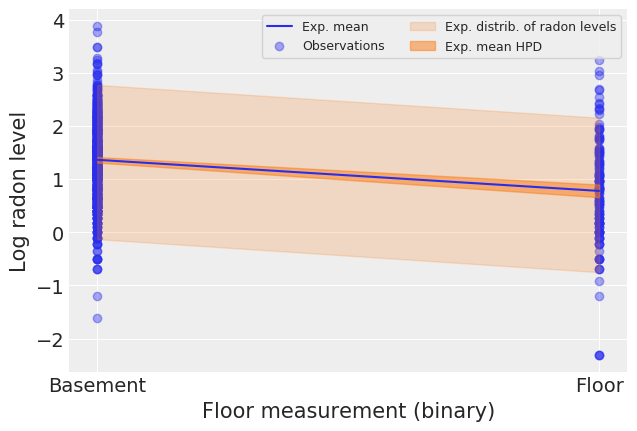

In [48]:
a_basement, a_floor = pooled_trace["a"].mean(axis=0)
radon_basement, radon_floor = ppc[:, 1], ppc[:, 0] # we know that floor=0/1 at these columns

plt.scatter(floor, log_radon, label="Observations", alpha=0.4)

az.plot_hpd(
    [0, 1], 
    np.asarray([radon_basement, radon_floor]).T, 
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of radon levels"}
)
az.plot_hpd(
    [0, 1], 
    pooled_trace["a"], 
    fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"}
)
plt.plot([0, 1], [a_basement, a_floor], label="Exp. mean")

plt.xticks([0,1], ["Basement", "Floor"])
plt.xlabel("Floor measurement (binary)")
plt.ylabel("Log radon level")
plt.legend(ncol=2, fontsize=9, frameon=True);

The 94% interval of the expected value is very narrow, and even narrower for basement measurements, meaning that the model is slightly more confident about these observations. The sampling distribution of individual radon levels is much wider. We can infer that floor level does account for some of the variation in radon levels. We can see however that the model underestimates the dispersion in radon levels across households -- lots of them lie outside the light orange prediction envelop. So this model is a good start but we can't stop there.

Let's compare it to the unpooled model, where we estimate the radon level for each county:

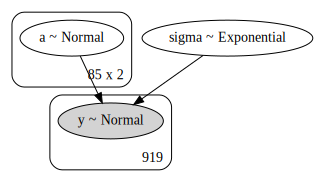

In [12]:
with pm.Model() as unpooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=(counties, 2))
    
    theta = a[county, floor]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
pm.model_to_graphviz(unpooled_model)

In [13]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, tune=2000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a]


Sampling went fine again. Let's look at the expected values for both basement (dimension 0) and floor (dimension 1) in each county:

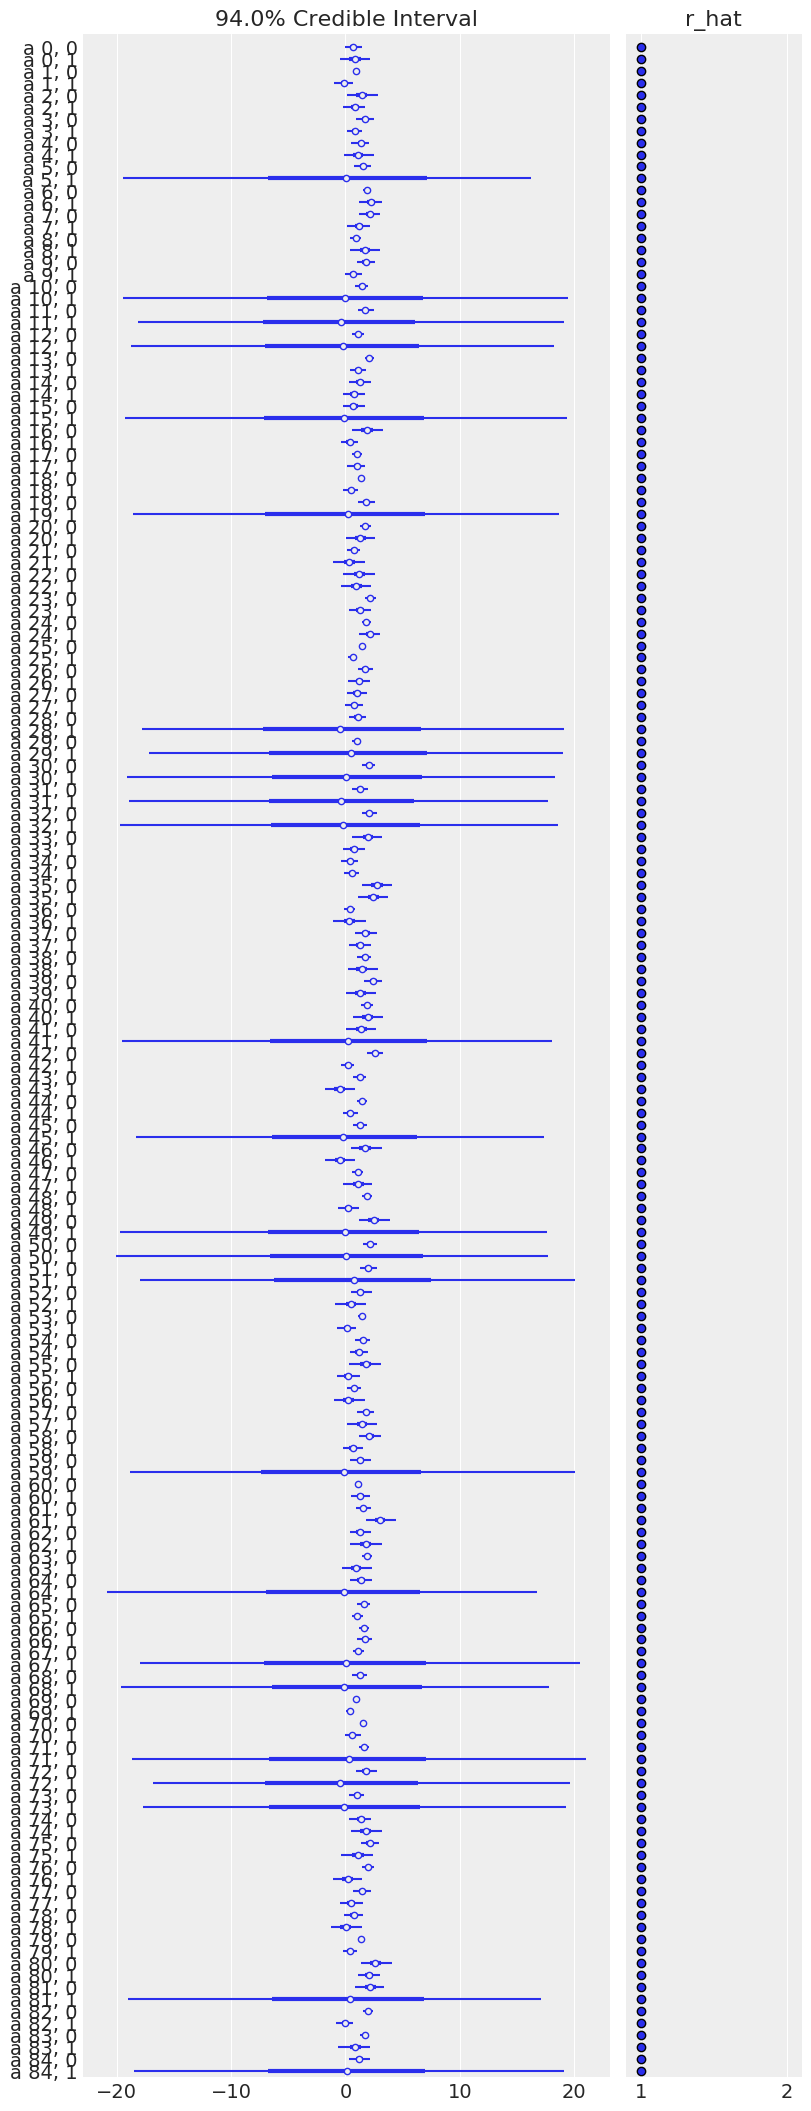

In [49]:
az.plot_forest(unpooled_trace, var_names=['a'], figsize=(6, 32), r_hat=True, combined=True);

Sampling was good for all counties, but you can see that some are more uncertain than others, and all of these uncertain estimates are for floor measurements. This probably comes from the fact that some counties just have a handful of floor measurements, so the model is pretty uncertain about them.

To identify counties with high radon levels, we can plot the ordered mean estimates, as well as their 94% HPD:

In [15]:
a_basement_unpooled, a_floor_unpooled = unpooled_trace["a"][:, :, 0], unpooled_trace["a"][:, :, 1]
unpooled_basement = pd.DataFrame.from_dict(
                        {
                            "basement": a_basement_unpooled.mean(0), 
                            "low": az.hpd(a_basement_unpooled)[:, 0], 
                            "high": az.hpd(a_basement_unpooled)[:, 1]
                        }, 
                        orient="index", 
                        columns=mn_counties
                    ).T.sort_values(by="basement")
unpooled_floor = pd.DataFrame.from_dict(
                    {
                        "floor": a_floor_unpooled.mean(0),
                        "low": az.hpd(a_floor_unpooled)[:, 0], 
                        "high": az.hpd(a_floor_unpooled)[:, 1]
                    }, 
                    orient="index", 
                    columns=mn_counties
                ).T.sort_values(by="floor")

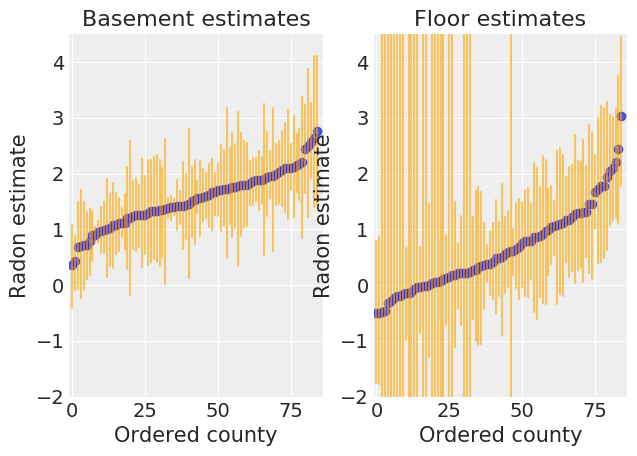

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, estimates, level in zip(axes, [unpooled_basement, unpooled_floor], ["basement", "floor"]):    
    for i, l, h in zip(range(counties), estimates.low.values, estimates.high.values):
        ax.plot([i, i], [l, h], alpha=0.6, c='orange')
    ax.scatter(range(counties), estimates[level], alpha=0.8)
    ax.set(title=f"{level.title()} estimates", xlabel="Ordered county", xlim=(-1, 86), ylabel="Radon estimate", ylim=(-2, 4.5));

There seems to be more dispersion in radon levels for floor measurements than for basement ones. Moreover, as we saw in the forest plot, floor estimates are globally more uncertain, especially in some counties. We speculated that this is due to smaller sample sizes in the data, but let's verify it!

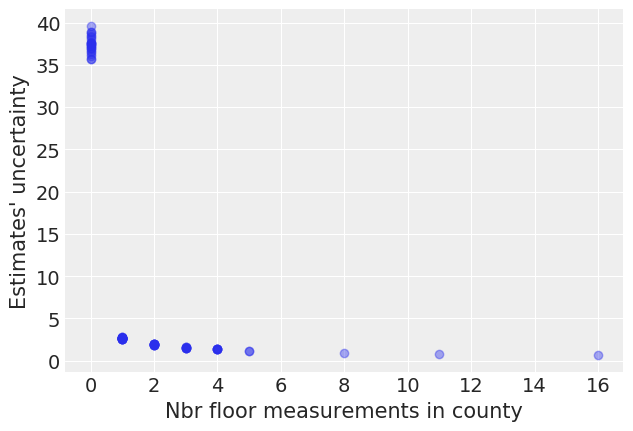

In [51]:
n_floor_meas = srrs_mn.groupby("county").sum().floor
uncertainty = (unpooled_floor.high - unpooled_floor.low).sort_index() # sort index to match counties alphabetically

plt.plot(n_floor_meas, uncertainty, 'o', alpha=.4)
plt.xlabel("Nbr floor measurements in county")
plt.ylabel("Estimates' uncertainty");

Bingo! This makes sense: it's very hard to estimate floor radon levels in counties where there are no floor measurements, and the model is telling us that by being very uncertain in its estimates for those counties. This is a classic issue with no-pooling models: when you estimate clusters independently from each other, what do you with small-sample-size counties?

Another way to see this phenomenon is to visually compare the pooled and unpooled estimates for a subset of counties representing a range of sample sizes:

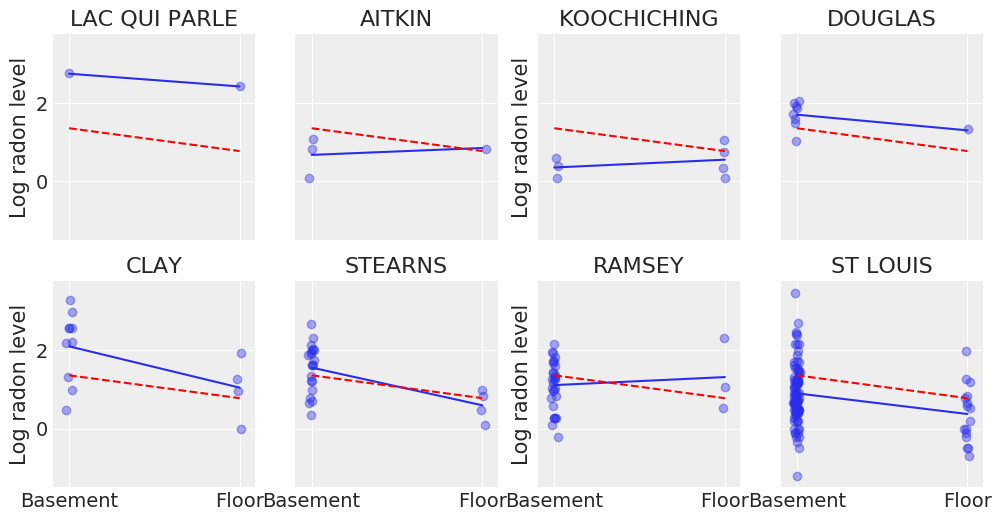

In [18]:
SAMPLE_COUNTIES = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(SAMPLE_COUNTIES):
    x = srrs_mn.floor[srrs_mn.county==c]
    y = srrs_mn.log_radon[srrs_mn.county==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # plot both models:
    axes[i].plot([0, 1], [unpooled_basement.loc[c, "basement"] , unpooled_floor.loc[c, "floor"]])
    axes[i].plot([0, 1], [a_basement, a_floor], "r--")
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["Basement", "Floor"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log radon level")

Neither of these models are satisfactory:

* If we are trying to identify high-radon counties, pooling is useless -- because, by definition, the pooled model estimates radon at the state-level. In other words, pooling leads to maximal *underfitting*: the variation across counties is not taken into account and only the overall population is estimated.
* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal *overfitting*: only the within-county variations are taken into account and the overall population (i.e the state-level, which tells us about similarites across counties) is not estimated. 

This issue is acute for small sample sizes, as seen above: in counties where we have few floor measurements, if radon levels are higher for those data points than for basement ones (Aitkin, Koochiching, Ramsey), the model will estimate that radon levels are higher in floors than basements for these counties. But we shouldn't trust this conclusion, because both scientific knowledge and the situation in other counties tell us that it is usually the reverse (basement radon > floor radon). So unless we have a lot of observations telling us otherwise for a given county, we should be skeptical and shrink our county-estimates to the state-estimates -- in other words, we should balance between cluster-level and population-level information, and the amount of shrinkage will depend on how extreme and how numerous the data in each cluster are. 

But how do we do that? Well, ladies and gentlemen, let me introduce you to... hierarchical models!

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that counties are all the same:

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that counties have no similarity whatsoever:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates and will influence the the state-wide average.

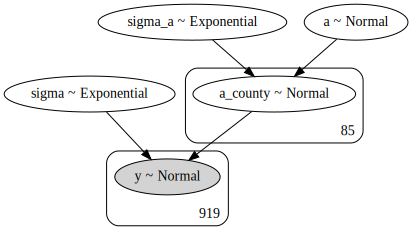

In [19]:
with pm.Model() as partial_pooling:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_county = pm.Normal('a_county', mu=a, sigma=sigma_a, shape=counties)
    
    # Expected value per county:
    theta = a_county[county]
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
pm.model_to_graphviz(partial_pooling)

In [20]:
with partial_pooling:
    partial_pooling_trace = pm.sample(1000, tune=2000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a_county, sigma_a, a]


The number of effective samples is smaller than 25% for some parameters.


To compare partial-pooling and no-pooling estimates, let's run the unpooled model without the `floor` predictor:

In [21]:
with pm.Model() as unpooled_bis:
    a_county = pm.Normal('a_county', 0., sigma=10., shape=counties)
    
    theta = a_county[county]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    unpooled_trace_bis = pm.sample(1000, tune=2000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a_county]


Now let's compare both models' estimates for all 85 counties. We'll plot the estimates against each county's sample size, to let you see more clearly what hierarchical models bring to the table:

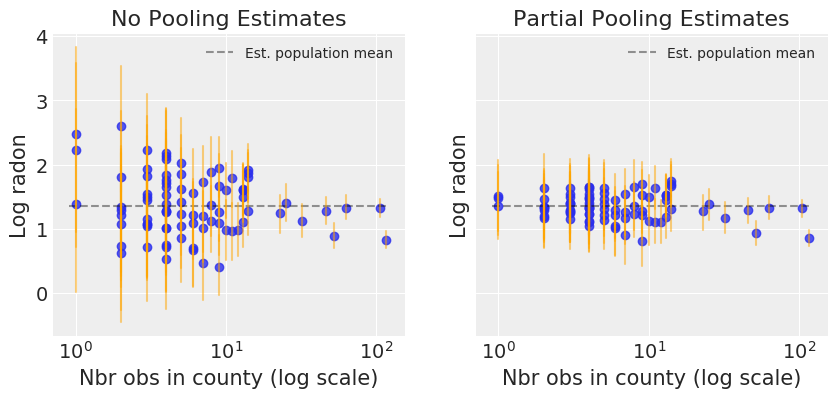

In [55]:
N_county = srrs_mn.groupby("county")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes, 
    [unpooled_trace_bis["a_county"], partial_pooling_trace["a_county"]], 
    ["no pooling", "partial pooling"]
):
    ax.hlines(
        partial_pooling_trace["a"].mean(), 
        0.9, 
        max(N_county) + 1, 
        alpha=0.4, 
        ls="--", 
        label="Est. population mean"
    )
    for n, l, h in zip(
        N_county, 
        az.hpd(trace)[:, 0], 
        az.hpd(trace)[:, 1]
    ):
        ax.plot([n, n], [l, h], alpha=0.5, c="orange")
    ax.scatter(N_county, trace.mean(0), alpha=0.8)
    ax.set(
        title=f"{level.title()} Estimates", 
        xlabel="Nbr obs in county (log scale)", 
        xscale="log", 
        ylabel="Log radon"
    )
    ax.legend(fontsize=10);

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size counties are informed by the population parameters -- hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) -- hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in counties where data is sparse. 

Now let's try to integrate the `floor` predictor! To show you an example with a slope we're gonna take the indicator variable road, but we could stay with the index variable approach that we used for the no-pooling model. Then we would have one intercept for each category -- basement and floor.

## Varying intercept model

As above, this model allows intercepts to vary across county, according to a random effect. We just add a fixed slope for the predictor (i.e all counties will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the no-pooling model, we set a separate intercept for each county, but rather than fitting separate regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data. Here is what that looks in code:

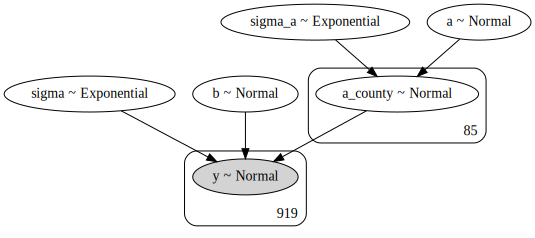

In [23]:
with pm.Model() as varying_intercept:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_county = pm.Normal('a_county', mu=a, sigma=sigma_a, shape=counties)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=10.)
    
    # Expected value per county:
    theta = a_county[county] + b * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
pm.model_to_graphviz(varying_intercept)

Let's fit this bad boy with MCMC:

In [24]:
with varying_intercept:
    varying_intercept_trace = pm.sample(1000, tune=2000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


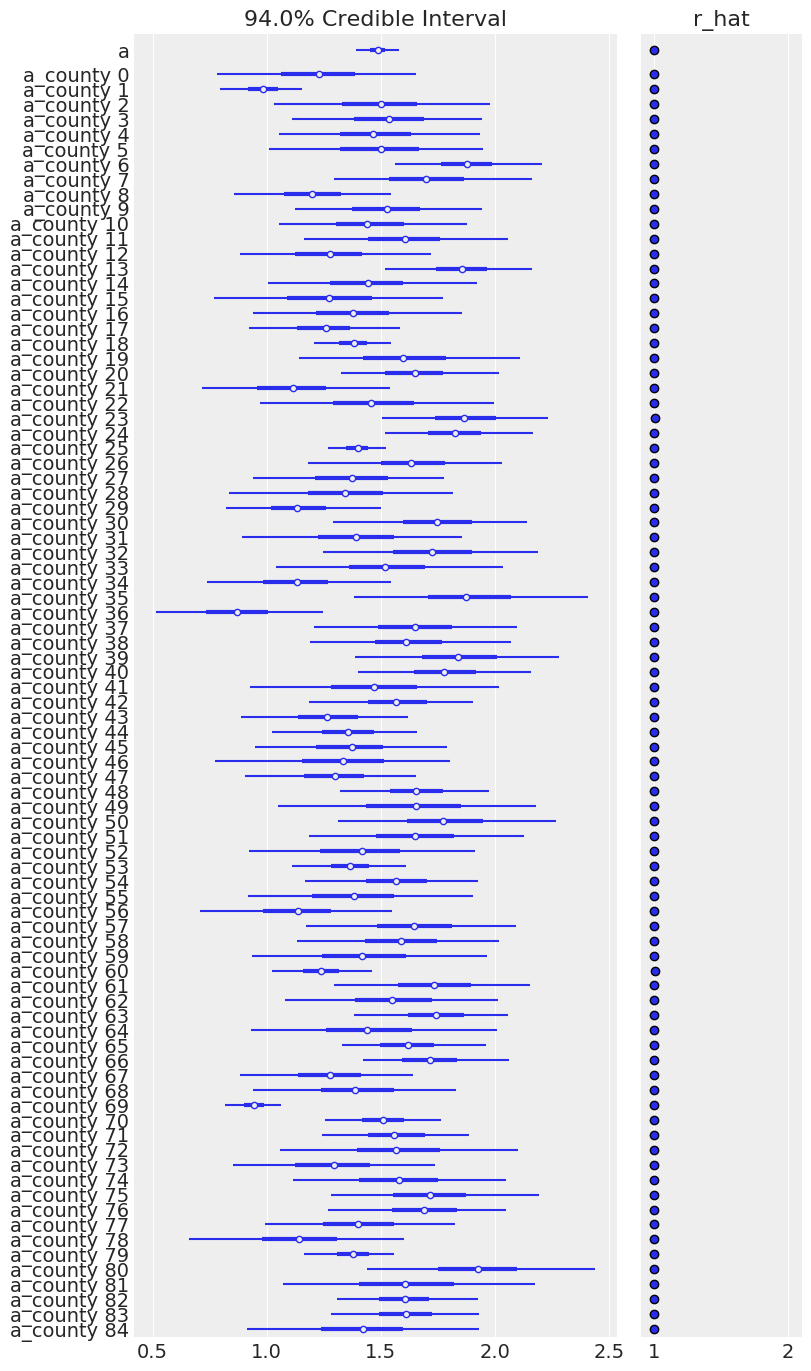

In [25]:
az.plot_forest(varying_intercept_trace, var_names=["a", "a_county"], r_hat=True, combined=True);

/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


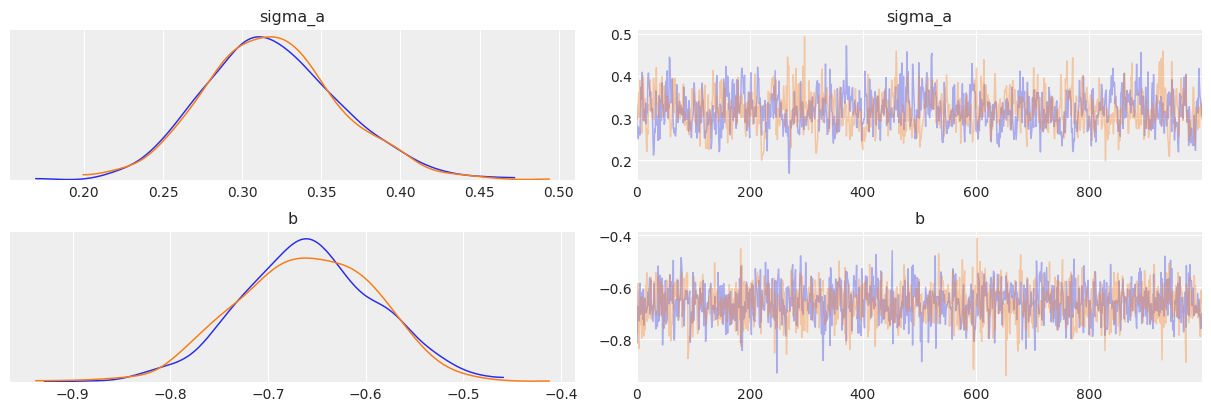

In [26]:
az.plot_trace(varying_intercept_trace, var_names=["sigma_a", "b"]);

In [27]:
az.summary(varying_intercept_trace, var_names=["a", "sigma_a", "b", "sigma"], round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,1.49,0.05,1.39,1.58,0.0,0.0,884.42,884.42,883.16,1091.78,1.0
sigma_a,0.32,0.04,0.25,0.40,0.0,0.0,589.82,589.82,584.67,878.16,1.0
b,-0.66,0.07,-0.79,-0.53,0.0,0.0,1437.78,1416.41,1448.72,1413.76,1.0
sigma,0.73,0.02,0.69,0.76,0.0,0.0,1727.37,1726.83,1729.66,1370.58,1.0


As we suspected, the estimate for the `floor` coefficient is reliably negative and centered around -0.66. This can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county. Note that this is only the *relative* effect of floor on radon levels: conditional on being in a given county, radon is expected to be half lower in houses without basements than in houses with. To see how much difference a basement makes on the *absolute* level of radon, we'd have to push the parameters through the model, as we do with posterior predictive checks and as we'll do just now.

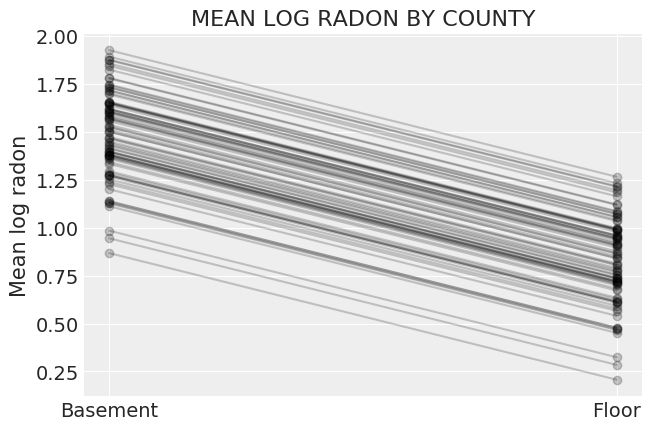

In [56]:
xvals = np.arange(2)
avg_a_county = varying_intercept_trace["a_county"].mean(0)
avg_b = varying_intercept_trace["b"].mean()

for a_c in avg_a_county:
    plt.plot(xvals, a_c + avg_b * xvals, 'ko-', alpha=0.2)
plt.xticks([0,1], ["Basement", "Floor"])
plt.ylabel("Mean log radon")
plt.title("MEAN LOG RADON BY COUNTY");

The graph above shows, for each county, the expected log radon level and the average effect of having no basement -- these are the absolute effects we were talking about. Two caveats though:
1. This graph doesn't show the uncertainty for each county -- how confident are we that the average estimates are where the graph shows? For that we'd need to combine the uncertainty in `a_county` and `b`, and this would of course vary by county. I didn't show it here because the graph would get cluttered, but go ahead and do it for a subset of counties.
2. These are only *average* estimates at the *county-level* (`theta` in the model): they don't take into account the variation by household. To add this other layer of uncertainty we'd need to take stock of the effect of `sigma` and generate samples from the `y` variable to see the effect on given households (that's exactly the role of posterior predictive checks).

That being said, it is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes:

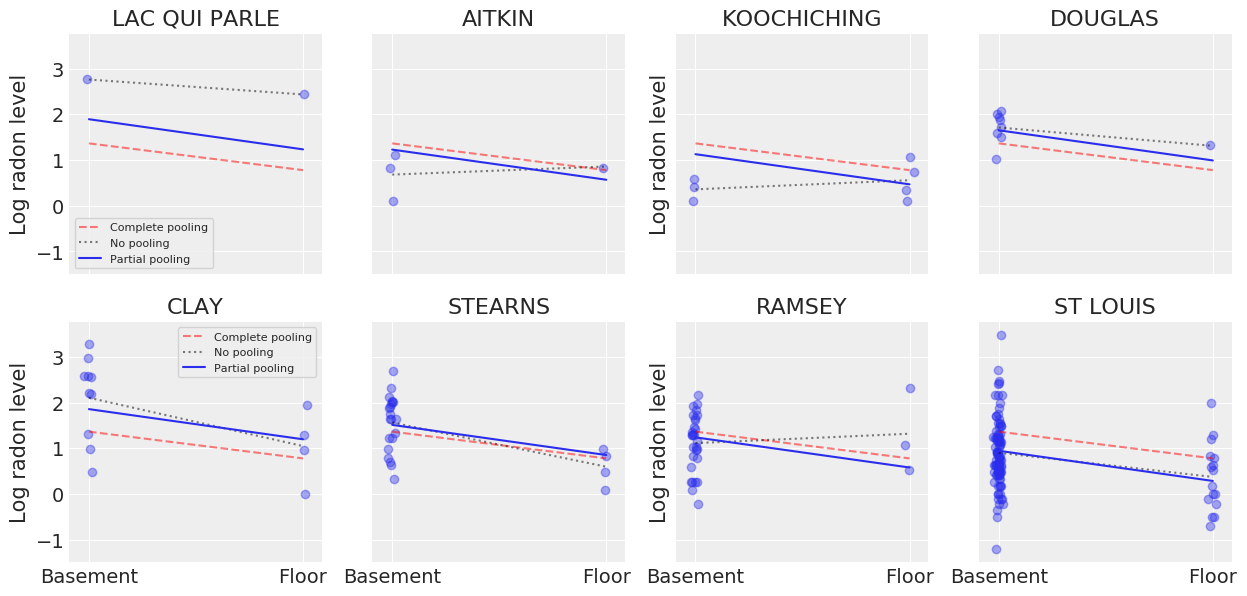

In [58]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(SAMPLE_COUNTIES):
    x = srrs_mn.floor[srrs_mn.county==c]
    y = srrs_mn.log_radon[srrs_mn.county==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    # complete-pooling model:
    axes[i].plot([0, 1], [a_basement, a_floor], "r--", alpha=0.5, label="Complete pooling")
    # no-pooling model:
    axes[i].plot(
        [0, 1], 
        [unpooled_basement.loc[c, "basement"] , unpooled_floor.loc[c, "floor"]],
        "k:",
        alpha=0.5,
        label="No pooling"
    )
    # partial-pooling model:
    axes[i].plot(
        [0, 1], 
        [avg_a_county[county_lookup[c]], avg_a_county[county_lookup[c]] + avg_b],
        label="Partial pooling"
    )
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["Basement", "Floor"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log radon level")
    if not i%4:
        axes[i].legend(fontsize=8, frameon=True)

Here we clearly see the notion that partial-pooling is a compromise between no pooling and complete pooling, as its mean estimates are usually between the other models' estimates. And interestingly, the bigger (smaller) the sample size in a given county, the closer the partial-pooling estimates are to the no-pooling (complete-pooling) estimates.

We see however that counties vary by more than just their baseline rates: the effect of floor seems to be different from one county to another. It would be great if our model could take that into account, wouldn't it? Well to do that, we need to allow the slope to vary by county -- not only the intercept -- and here is how you can do it with PyMC3.

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

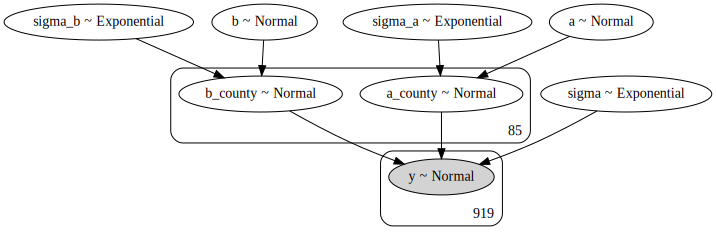

In [30]:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.5)
    sigma_b = pm.Exponential('sigma_b', 1.)
    
    # Varying intercepts:
    a_county = pm.Normal('a_county', mu=a, sigma=sigma_a, shape=counties)
    # Varying slopes:
    b_county = pm.Normal('b_county', mu=b, sigma=sigma_b, shape=counties)
    
    # Expected value per county:
    theta = a_county[county] + b_county[county] * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
pm.model_to_graphviz(varying_intercept_slope)

Now, if you run this model, you'll get divergences (some or a lot, depending on your random seed). We don't want that -- divergences are your Voldemort to your models. In these situations it's usually wise to reparametrize your model using the "non-centered parametrization" (I know, it's really not a great term, but please indulge me). We're not gonna explain it here, but there are [great resources out there](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/). In a nutshell, it's an algebraic trick that helps computation but leaves the model unchanged -- the model is statistically equivalent to the "centered" version. In that case, here is what it would look like:

In [31]:
with pm.Model() as varying_intercept_slope:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    b = pm.Normal('b', mu=0., sigma=1.5)
    sigma_b = pm.Exponential('sigma_b', 1.)
    
    # Varying intercepts:
    za_county = pm.Normal('za_county', mu=0., sigma=1., shape=counties)
    # Varying slopes:
    zb_county = pm.Normal('zb_county', mu=0., sigma=1., shape=counties)
    
    # Expected value per county:
    theta = (a + za_county[county] * sigma_a) + (b + zb_county[county] * sigma_b) * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    varying_intercept_slope_trace = pm.sample(1000, tune=8000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, zb_county, za_county, sigma_b, b, sigma_a, a]


The number of effective samples is smaller than 25% for some parameters.


True, the code is uglier (for you, not for the computer), but:
1. The interpretation stays pretty much the same: `a` and `b` are still the mean state-wide intercept and slope. `sigma_a` and `sigma_b` still estimate the dispersion across counties of the intercepts and slopes (the more alike the counties, the smaller the corresponding sigma). The big change is that now the counties estimates (`za_county` and `zb_county`) are z-scores. But the strategy to see what this means for mean radon levels per county is the same: push all these parameters through the model to get samples from `theta`.
2. We don't have any divergence: the model sampled more efficiently and converged more quickly than in the centered form.

Notice however that we had to increse the number of tuning steps. Looking at the trace helps us understand why:

/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/pymc-dev/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/alex_andorra/

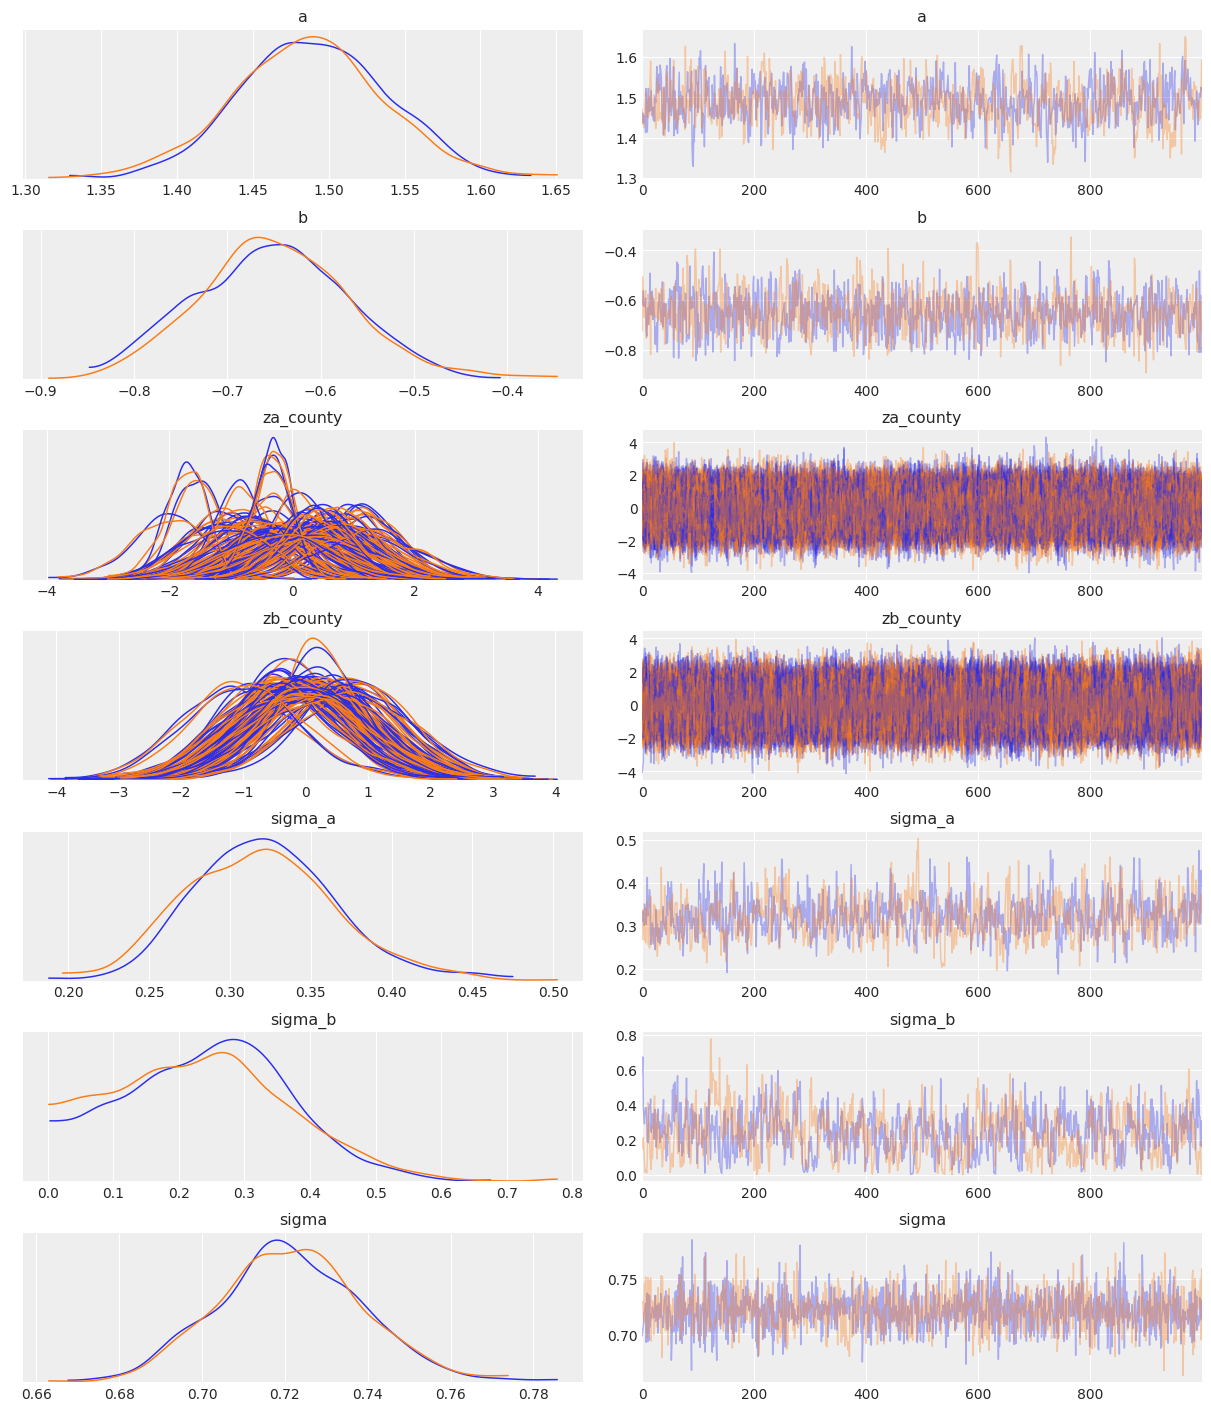

In [32]:
az.plot_trace(varying_intercept_slope_trace, compact=True);

All chains look good and we get a negative `b` coefficient, illustrating the mean downward effect of no-basement on radon levels at the state level. But notice that `sigma_b` often gets very near zero -- which would indicate that counties don't vary that much in their answer to the `floor` "treatment". That's probably what bugged MCMC when using the centered parametrization: these situations usually yield a weird geometry for the sampler, causing the divergences. In other words, the non-centered form often perfoms better when one of the sigmas gets close to zero. But here, even with the non-centered model the sampler is not that comfortable with `sigma_b`: in fact if you look at the estimates with `az.summary` you'll probably see that the number of effective samples is quite low for `sigma_b`.

Also note that `sigma_a` is not that big either -- i.e counties do differ in their baseline radon levels, but not by a lot. However we don't that much of a problem to sample from this distribution because it's much narrower than `sigma_b` and doesn't get dangerously close to 0.

To wrap up this model, let's plot the relationship between radon and floor for each county:

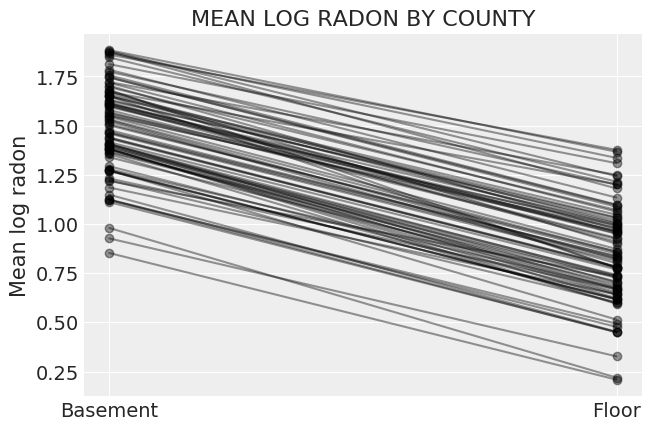

In [59]:
xvals = np.arange(2)
avg_a_county = (
    varying_intercept_slope_trace["a"].mean() 
    + varying_intercept_slope_trace["za_county"].mean(0) 
    * varying_intercept_slope_trace["sigma_a"].mean()
)
avg_b_county = (
    varying_intercept_slope_trace["b"].mean() 
    + varying_intercept_slope_trace["zb_county"].mean(0) 
    * varying_intercept_slope_trace["sigma_b"].mean()
)

for a_c, b_c in zip(avg_a_county, avg_b_county):
    plt.plot(xvals, a_c + b_c * xvals, 'ko-', alpha=0.4)
plt.xticks([0,1], ["Basement", "Floor"])
plt.ylabel("Mean log radon")
plt.title("MEAN LOG RADON BY COUNTY");

With the same caveats as earlier, we can see that now *both* the intercept and the slope vary by county -- and isn't that a marvel of statistics? But wait, there is more!

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation, $\sigma_{\alpha}$ (here it would be the variation across counties, `sigma_a`). An important implication of this is that the group-level estimate induces stronger pooling -- by definition, a smaller $\sigma_{\alpha}$ means a stronger shrinkage of counties parameters towards the overall state mean. 

This is fairly straightforward to implement in PyMC3 -- we just add another level:

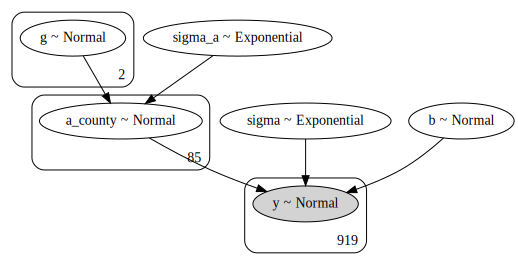

In [34]:
with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts uranium model:
    a = g[0] + g[1] * u
    a_county = pm.Normal('a_county', mu=a, sigma=sigma_a, shape=counties)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.5)
    
    # Expected value per county:
    theta = a_county[county] + b * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
pm.model_to_graphviz(hierarchical_intercept)

Do you see the new level, with `sigma_a` and `g`, which is two-dimensional because it contains the linear model for `a_county`? Now, if we run this model we're gonna get... divergences, you guessed it! So we're gonna switch to the non-centered form again:

In [35]:
with pm.Model() as hierarchical_intercept:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=2)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts uranium model:
    a = pm.Deterministic('a', g[0] + g[1] * u)
    za_county = pm.Normal('za_county', mu=0., sigma=1., shape=counties)
    a_county = pm.Deterministic('a_county', a + za_county * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.5)
    
    # Expected value per county:
    theta = a_county[county] + b * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    hierarchical_intercept_trace = pm.sample(1000, tune=8000, chains=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, b, za_county, sigma_a, g]


The number of effective samples is smaller than 25% for some parameters.


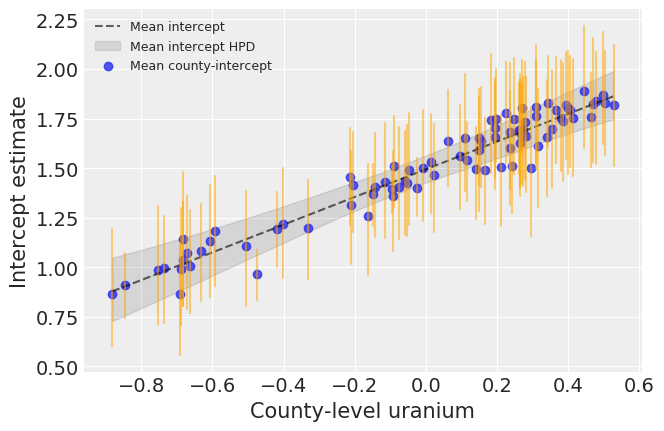

In [61]:
samples = hierarchical_intercept_trace
avg_a = samples['a'].mean(0)
avg_a_county = samples['a_county'].mean(0)

plt.plot(
    u[np.argsort(u)], 
    avg_a[np.argsort(u)], 
    "k--", 
    alpha=0.6,
    label="Mean intercept"
)
az.plot_hpd(
    u, 
    samples['a'],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"}
)

plt.scatter(u, avg_a_county, alpha=0.8, label="Mean county-intercept")
for ui, l, h in zip(
    u, 
    az.hpd(samples["a_county"])[:, 0], 
    az.hpd(samples["a_county"])[:, 1]
):
    plt.plot([ui, ui], [l, h], alpha=0.5, c="orange")

plt.xlabel("County-level uranium"); plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

Uranium is indeed much associated with baseline radon levels in each county. The graph above shows the average relationship and its uncertainty: the baseline radon level in an average county as a function of uranium, as well as the 94% HPD of this radon level (grey line and envelope). The blue points and orange bars represent the relationship between baseline radon and uranium, but now for each county. As you see, the uncertainty is bigger now, because it adds on top of the average uncertainty -- each county has its idyosyncracies after all.

If we compare the county-intercepts for this model with those of the partial-pooling model without a county-level covariate:

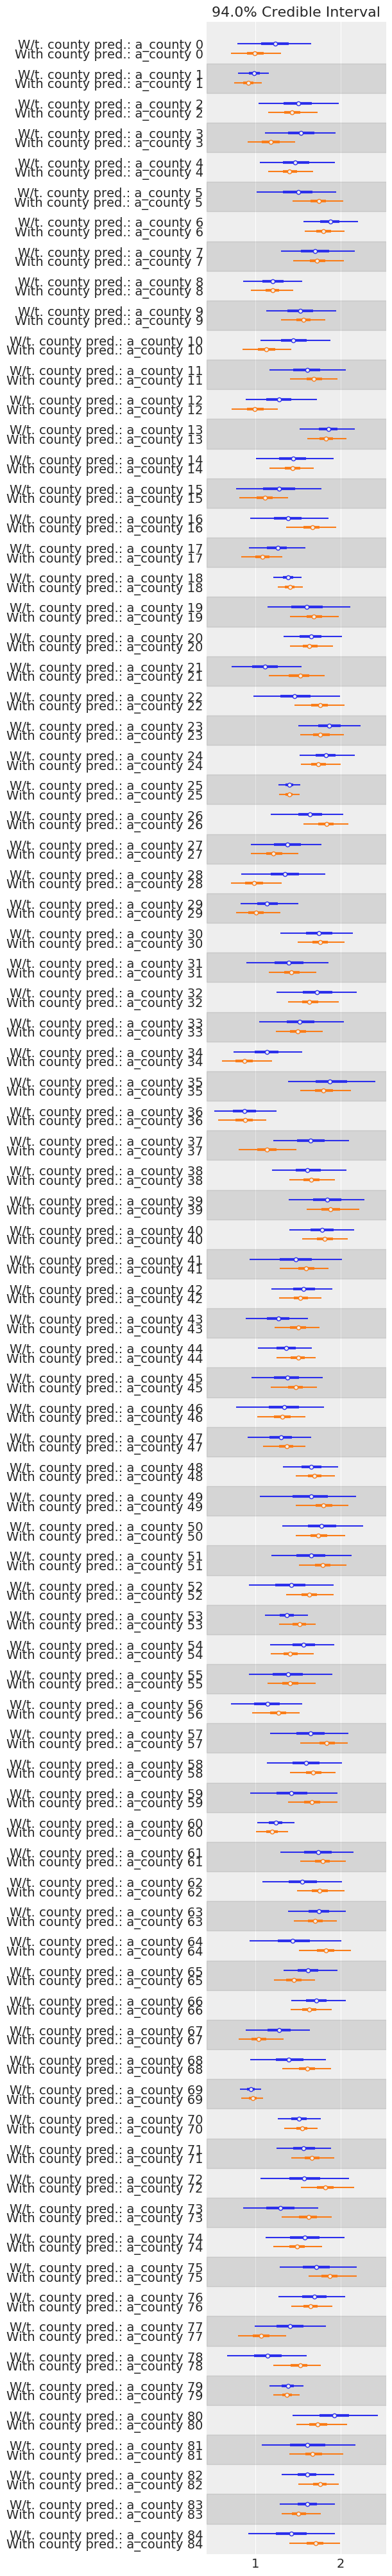

In [63]:
az.plot_forest([varying_intercept_trace, hierarchical_intercept_trace], 
               model_names=["W/t. county pred.", "With county pred."], 
               var_names=["a_county"], 
               combined=True,
               figsize=(6, 40));

We see that the compatibility intervals are narrower for the model including the county-level covariate. This is expected, as the effect of a covariate is to reduce the variation in the outcome variable -- provided the covariate is of predictive value. More importantly, with this model we were able to squeeze even more information out of the data.

## Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

To add these effects to our model, let's create a new variable containing the mean of `floor` in each county and add that to our previous model:

In [38]:
avg_floor = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

with pm.Model() as contextual_effect:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=3)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts uranium model:
    a = pm.Deterministic('a', g[0] + g[1] * u + g[2] * avg_floor)
    za_county = pm.Normal('za_county', mu=0., sigma=1., shape=counties)
    a_county = pm.Deterministic('a_county', a + za_county * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.5)
    
    # Expected value per county:
    theta = a_county[county] + b * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    contextual_effect_trace = pm.sample(1000, tune=10_000, chains=2, random_seed=RANDOM_SEED)
az.summary(contextual_effect_trace, var_names=["g"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, b, za_county, sigma_a, g]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g[0],1.43,0.05,1.33,1.52,0.0,0.0,1713.75,1684.96,1742.00,1080.33,1.0
g[1],0.70,0.08,0.53,0.84,0.0,0.0,2109.92,2109.92,2123.44,1415.06,1.0
g[2],0.39,0.19,0.01,0.75,0.0,0.0,2068.88,1979.55,2080.52,1232.35,1.0


So we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. This seems to be new, as up to this point we saw that `floor` was *negatively* associated with radon levels. But remember this was at the household-level: radon tends to be higher in houses with basements. But at the county-level it seems that the less basements on average in the county, the more radon. So it's not that contradictory. What's more, the estimate for $\gamma_2$ is quite uncertain and overlaps with zero, so it's possible that the relationship is not that strong. And finally, let's note that $\gamma_2$ estimates something else than uranium's effect, as this is already taken into account by $\gamma_1$ -- it answers the question "once we know uranium level in the county, is there any value in learning about the proportion of houses without basements?".

All of this is to say that we shouldn't interpret this causally: there is no credible mecanism by which a basement (or absence thereof) *causes* radon emissions. More probably, our causal graph is missing something: a confounding variable, one that influences both basement construction and radon levels, is lurking somewhere in the dark... Perhaps is it the type of soil, which might influence what type of structures are built *and* the level of radon? Maybe adding this to our model would help with causal inference.

## Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an *existing* group
2. a new individual within a *new* group

The first type is the easiest one, as we've generally already sampled from the existing group. For this model, the first type of posterior prediction is the only one making sense, as counties are not added or deleted every day. So, if we wanted to make a prediction for, say, a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept:

In [39]:
county_lookup["ST LOUIS"]

69

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is simply a matter of adding a single additional line to our previous model:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [stl_pred, sigma, b, za_county, sigma_a, g]


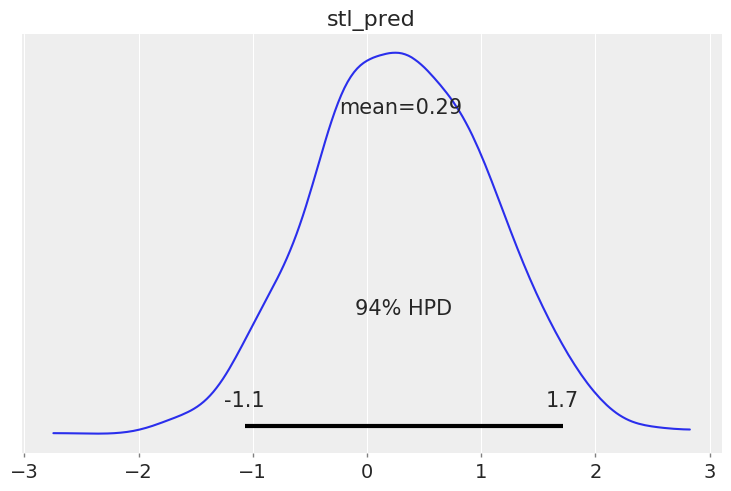

In [40]:
with pm.Model() as contextual_pred:
    # Hyperpriors:
    g = pm.Normal('g', mu=0., sigma=10., shape=3)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts uranium model:
    a = pm.Deterministic('a', g[0] + g[1] * u + g[2] * avg_floor)
    za_county = pm.Normal('za_county', mu=0., sigma=1., shape=counties)
    a_county = pm.Deterministic('a_county', a + za_county * sigma_a)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=1.5)
    
    # Expected value per county:
    theta = a_county[county] + b * floor
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    # St Louis county prediction:
    stl_pred = pm.Normal('stl_pred', mu=a_county[69] + b, sigma=sigma)
    
    contextual_pred_trace = pm.sample(1000, tune=8000, chains=2, random_seed=RANDOM_SEED)
az.plot_posterior(contextual_pred_trace, var_names=['stl_pred']);

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data

- Estimation of coefficients for (under-represented) groups

- Incorporating individual- and group-level information when estimating group-level coefficients

- Allowing for variation among individual-level coefficients across groups

## References

- Gelman, A., & Hill, J. (2006), *Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.)*, Cambridge University Press.

- Gelman, A. (2006), *Multilevel (Hierarchical) modeling: what it can and cannot do*, Technometrics, 48(3), 432–435.

- McElreath, R. (2020), *Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.)*, CRC Press. 